In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
import itertools

import wandb
from wandb.integration.keras import WandbMetricsLogger

## Exploratory Image Analysis

In [4]:
base_dir = os.path.expanduser('dataset-resized')

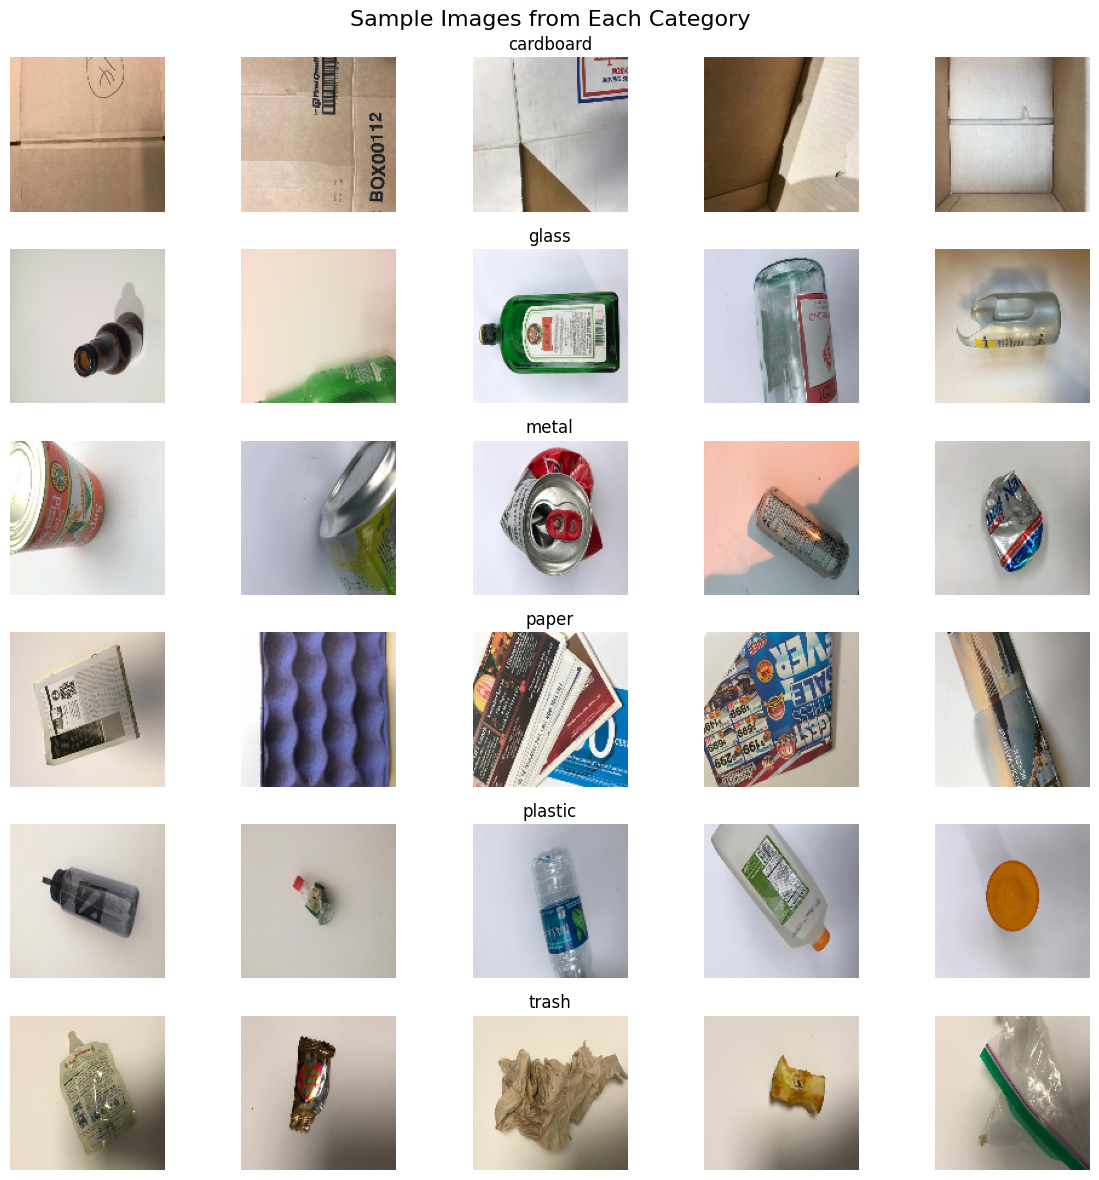

In [5]:
categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

n_sample = 5

fig, axes = plt.subplots(nrows=len(categories), ncols=n_sample, figsize=(12, 12))
fig.suptitle('Sample Images from Each Category', fontsize=16)

for i, category in enumerate(categories):
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)[:n_sample]
    for j, img in enumerate(images):
        img_path = os.path.join(category_dir, img)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 2:
            axes[i, j].set_title(category)

plt.tight_layout()
plt.show()

### Number of images per category

In [10]:
cat_counts = {}

for category in categories:
    cat_dir = os.path.join(base_dir, category)
    num_images = len([file for file in os.listdir(cat_dir) if os.path.isfile(os.path.join(cat_dir, file))])
    cat_counts[category] = num_images

print(cat_counts)

{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


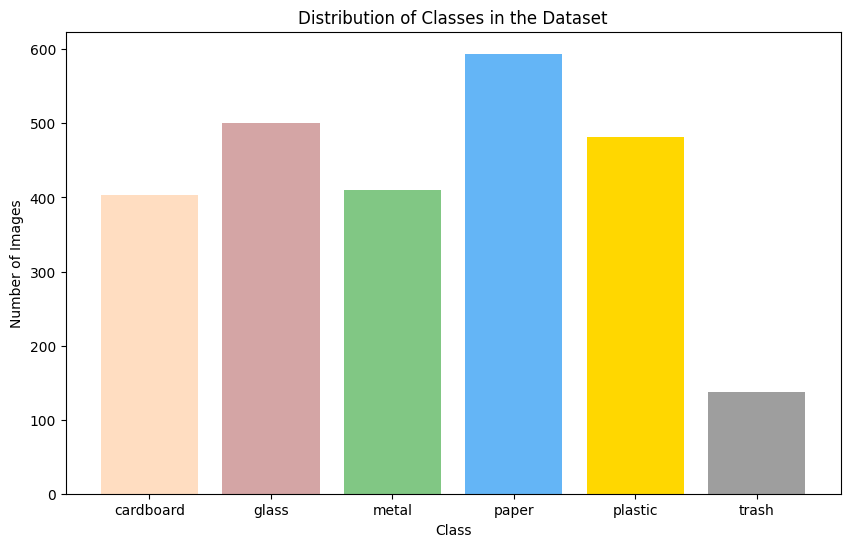

In [11]:
# Create lists for the classes and their respective counts
cat_names = list(cat_counts.keys())
counts = list(cat_counts.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(cat_names, counts, color=['#FFDDC1', '#D4A5A5', '#81C784', '#64B5F6', '#FFD700', '#9E9E9E'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in the Dataset')
plt.show()

### Create data generator

In [34]:
# # With data augmentation
# datagen = ImageDataGenerator(
#     rescale=1./255, 
#     validation_split=0.2,
#     width_shift_range=0.1, 
#     height_shift_range=0.1, 
#     horizontal_flip=True
# )

# Without data augmentation
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2
)


train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [35]:
train_generator.samples, train_generator.batch_size

(2024, 32)

In [36]:
validation_generator.samples, validation_generator.batch_size

(503, 32)

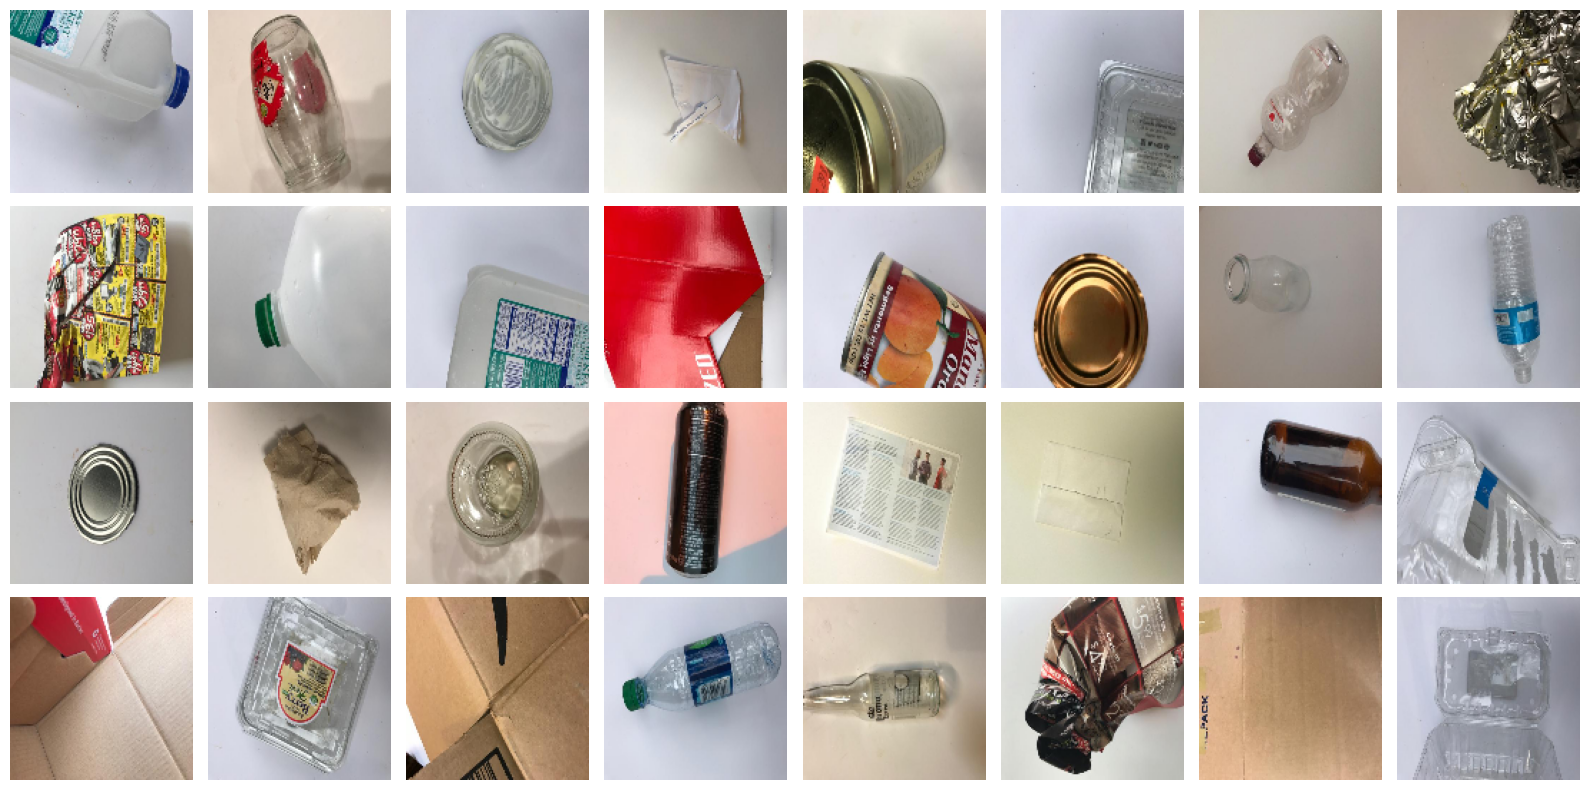

In [37]:
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
for i in range(32):
    ax = axes[i // 8, i % 8]
    ax.imshow(x_batch[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

Training set class distribution: 4579
Validation set class distribution: 1137


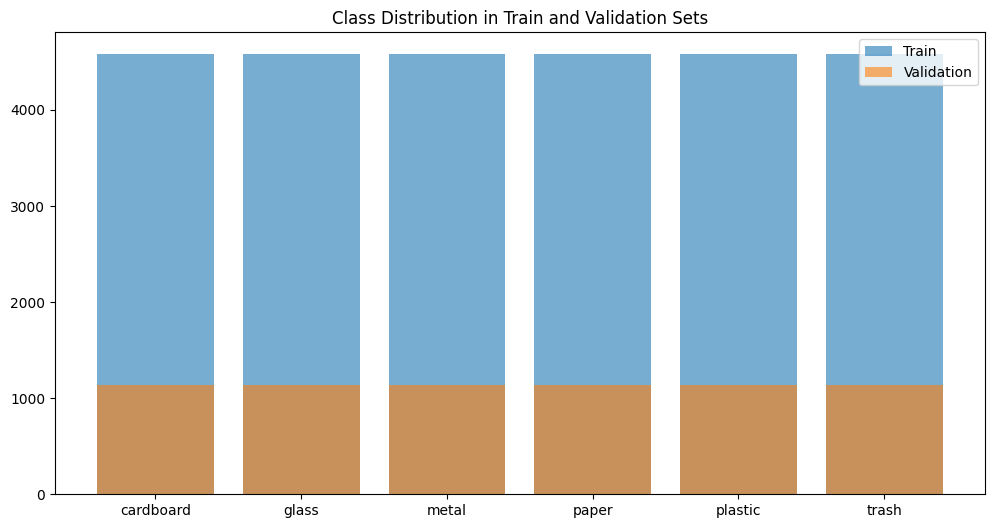

In [38]:
train_class_counts = np.sum(train_generator.labels, axis=0)
val_class_counts = np.sum(validation_generator.labels, axis=0)

print("Training set class distribution:", train_class_counts)
print("Validation set class distribution:", val_class_counts)

plt.figure(figsize=(12, 6))
plt.bar(categories, train_class_counts, alpha=0.6, label='Train')
plt.bar(categories, val_class_counts, alpha=0.6, label='Validation')
plt.legend()
plt.title('Class Distribution in Train and Validation Sets')
plt.show()

## Model Experimentation

In [39]:
n_class = len(train_generator.class_indices)
print(n_class)

6


In [40]:
run = wandb.init(
    project="wandb-trash-classification",
    config={
        "learning_rate": 0.001,
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 32
    }
)

config = wandb.config

i = Input(shape=(128, 128, 3))  # Update the input shape to match your data

# Convolutional Layers {Conv --> BatchNorm --> Conv --> BatchNorm --> MaxPooling (3x)}
x = Conv2D(32, (3,3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Neural Networks Layer
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(n_class, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=config.epoch,
    callbacks=[
        WandbMetricsLogger()
    ]
)

# Save model locally
path = "./models/trash-classification-no-aug.keras"
model.save(path)

# Save model to W&B
path = "./models/trash-classification-no-aug.keras"
registered_model_name = "trash-classification-dev"

run.link_model(path=path, registered_model_name=registered_model_name)

print(f"The model has been trained and saved in W&B '{path}'")

wandb.finish()

Epoch 1/20


C:\Users\adven\anaconda3\envs\trash-classification\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 8:51 9s/step - accuracy: 0.1250 - loss: 3.479 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.1953 - loss: 3.422 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.2587 - loss: 3.273 ━━━━━━━━━━━━━━━━━━━━ 1:23 1s/step - accuracy: 0.2878 - loss: 3.297 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 0.3052 - loss: 3.380 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.3194 - loss: 3.476 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - accuracy: 0.3312 - loss: 3.551 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.3396 - loss: 3.633 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - accuracy: 0.3486 - loss: 3.696 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.3562 - loss: 3.742 ━━━━━━━━━━━━━━━━━━━━ 1:07 1s/step - accuracy: 0.3620 - loss: 3.802 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.3672 - loss: 3.851 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.3717 - loss: 3.884 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.3759 - loss: 3.901 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.3796 - l

C:\Users\adven\anaconda3\envs\trash-classification\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5000 - loss: 1.9229 - val_accuracy: 0.2609 - val_loss: 2.5275
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.6562 - loss: 0.866 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.7031 - loss: 0.761 ━━━━━━━━━━━━━━━━━━━━ 1:22 1s/step - accuracy: 0.7049 - loss: 0.755 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.7103 - loss: 0.740 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - accuracy: 0.7145 - loss: 0.726 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.7213 - loss: 0.709 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.7279 - loss: 0.691 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.7336 - loss: 0.677 ━━━━━━━━━━━━━━━━━━━━ 1:14 1s/step - accuracy: 0.7381 - loss: 0.666 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.7421 - loss: 0.656 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.7457 - loss: 0.646 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.7493 - loss: 0.635 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.7521 - loss: 0.6

epoch/accuracy,▂▁▅▅▇▅▇▇████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▂▃▂▁▂▂▂▄▄▄▅▃▆▆▇█▇▆██
epoch/val_loss,▃▃▆▆▇█▅▃▃▃▃▃▂▂▂▁▂▂▂▃
epoch/accuracy,0.96875
epoch/epoch,19
epoch/loss,0.04401
epoch/val_accuracy,0.65217
epoch/val_loss,2.02285


In [32]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 101,549,428 (387.38 MB)

 Trainable params: 33,849,510 (129.13 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 67,699,022 (258.25 MB)

### Tracking the training process with wandb

The image below is the model training history taken from wandb workspace 

<img src="./images/model_history.png" alt="Alternative text" />

The run name `splendid-butterfly-46` represents the model training **without data augmentation** and `fallen-yogurt-45` represents the model training **with data augmentation**.

While the `val_accuracy` is the same for both models at the 20th epoch (`0.65...`), the model trained without data augmentation tends to be overfit which is shown by the very fast decrease in the `training_loss` value. In my view, the model trained with data augmentation will perform much better along with the increasing epoch number due to the better generalisation. In the real case, we might try 30 or even 40 epochs to get the desired performance.